In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import seaborn as sns
from dateutil import parser
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import torch

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
# Load the datasets
file_path_newscomau = 'data_newscomau_withdates.csv'
file_path_aljazeera = 'data_aljazeera_withdates.csv'
file_path_reddit = 'reddit_data_combined.csv'

# Reading the data from each source
data_newscomau = pd.read_csv(file_path_newscomau)
data_aljazeera = pd.read_csv(file_path_aljazeera)
data_reddit = pd.read_csv(file_path_reddit)

In [47]:
 # Function to parse dates and handle different formats including 'nan'
def parse_date(date_str):
    if pd.isna(date_str) or date_str == 'nan':
        return pd.NA  # Or use None
    try:
        # Remove unwanted words and strip whitespace
        date_str = date_str.replace('Published On', '').replace('-','').strip()
        # Parse the date
        return parser.parse(date_str)
    except (ValueError, parser.ParserError):
        return pd.NA  # Or use None if the date can't be parsed

In [48]:
# Replace 'nan' string with actual NaN values
data_reddit['title'].replace('nan', pd.NA, inplace=True)
data_reddit['text'].replace('nan', pd.NA, inplace=True)

# Concatenate 'title' and 'text' columns while excluding NaN values
data_reddit['combined'] = data_reddit.apply(
    lambda row: ' '.join([str(part) for part in [row['title'], row['text']] if pd.notna(part)]), axis=1
)



# Set the source for each DataFrame
data_newscomau['source'] = 'News.com.au'
data_aljazeera['source'] = 'Al Jazeera'
data_reddit['source'] = 'Reddit'

# Combine all data into a single DataFrame
news_data = pd.concat([data_newscomau, data_aljazeera], ignore_index=True)

# Apply the function to the 'date' column to fix the format
news_data['date'] = news_data['date'].apply(parse_date)
news_data['date'] = pd.to_datetime(news_data['date'])

# Check the results
print(news_data['date'].head())

0   2023-12-08 12:33:00
1   2023-12-08 08:05:00
2   2023-12-07 20:43:00
3   2023-12-07 20:20:00
4   2023-12-06 11:01:00
Name: date, dtype: datetime64[ns]


                                date   word_count
count                            439   447.000000
mean   2023-11-16 14:28:47.425968128  1118.845638
min              2023-10-10 15:22:00     4.000000
25%              2023-10-29 09:34:30   544.500000
50%              2023-11-25 00:00:00   817.000000
75%              2023-12-01 04:52:00  1225.500000
max              2023-12-08 12:33:00  7645.000000
std                              NaN  1201.032426
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       447 non-null    object        
 1   url         447 non-null    object        
 2   body        447 non-null    object        
 3   date        439 non-null    datetime64[ns]
 4   source      447 non-null    object        
 5   word_count  447 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2

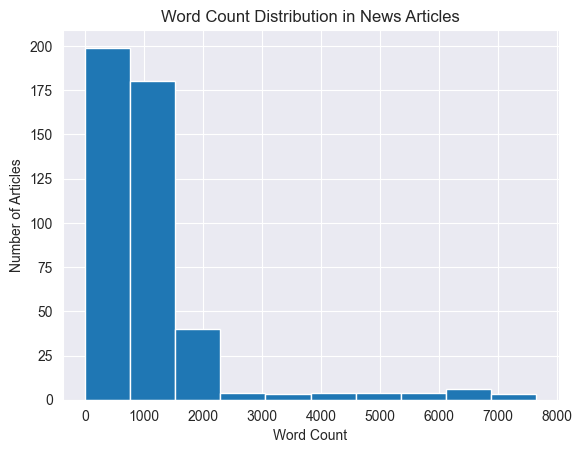

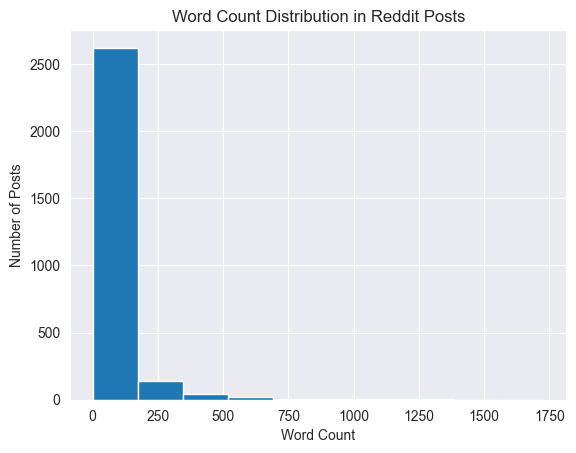

In [52]:
## Basic EDA
# Basic info and statistics
print(news_data.describe())
print(news_data.info())

# Check for missing values
print(news_data.isnull().sum()) # 8 missing date values

# Text statistics
news_data['word_count'] = news_data['body'].apply(lambda x: len(word_tokenize(x)))
data_reddit['word_count'] = data_reddit['combined'].apply(lambda x: len(word_tokenize(x)))

print(news_data['word_count'].describe())
print(data_reddit['word_count'].describe())

# Plotting word count distribution (News)
plt.hist(news_data['word_count'], bins=10)
plt.title('Word Count Distribution in News Articles')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

# Plotting word count distribution (Reddit)
plt.hist(data_reddit['word_count'], bins=10)
plt.title('Word Count Distribution in Reddit Posts')
plt.xlabel('Word Count')
plt.ylabel('Number of Posts')
plt.show()

In [37]:
# Convert non-string entries to strings
news_data['body'] = news_data['body'].astype(str)

# More Initial EDA: Basic information about the data
print("Basic Information:")
print(news_data.info())

# Show the distribution of sources
print("\nDistribution of sources:")
print(news_data['source'].value_counts())

# Check for any duplicate entries
duplicates = news_data.duplicated(subset=['title', 'body'], keep=False)
print(f"\nNumber of duplicate entries: {duplicates.sum()}")
# Remove duplicates if any
news_data = news_data[~duplicates]

print(news_data.describe())
print(news_data['source'].value_counts())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       447 non-null    object        
 1   url         447 non-null    object        
 2   body        447 non-null    object        
 3   date        439 non-null    datetime64[ns]
 4   source      447 non-null    object        
 5   word_count  447 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 21.1+ KB
None

Distribution of sources:
source
Al Jazeera     237
News.com.au    210
Name: count, dtype: int64

Number of duplicate entries: 0
                                date   word_count
count                            439   447.000000
mean   2023-11-16 14:28:47.425968128  1118.845638
min              2023-10-10 15:22:00     4.000000
25%              2023-10-29 09:34:30   544.500000
50%              2023-11-25 00:00:00   

In [44]:
## EDA Part 2

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the text column
news_data['processed_text'] = news_data['body'].apply(preprocess_text)
data_reddit['processed_text'] = data_reddit['combined'].apply(preprocess_text)

# Check for any empty strings in the 'processed_text' column
print("Empty strings before removal in news_data:", (news_data['processed_text'] == '').sum())
print("Empty strings before removal in data_reddit:", (data_reddit['processed_text'] == '').sum())

# Remove rows where 'processed_text' is an empty string
news_data = news_data[news_data['processed_text'] != '']
data_reddit = data_reddit[data_reddit['processed_text'] != '']

# Check for any empty strings in the 'processed_text' column after removal
print("Empty strings after removal in news_data:", (news_data['processed_text'] == '').sum())
print("Empty strings after removal in data_reddit:", (data_reddit['processed_text'] == '').sum())

# Most common words (excluding stop words) for News sites
all_words = ' '.join(news_data['processed_text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
print("Most common words (News):", most_common_words)

# Most common words (excluding stop words) for Reddit
all_words = ' '.join(data_reddit['processed_text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
print("Most common words (Reddit):", most_common_words)

Empty strings before removal in news_data: 0
Empty strings before removal in data_reddit: 0
Empty strings after removal in news_data: 0
Empty strings after removal in data_reddit: 0
Most common words (News): [('said', 3896), ('israel', 3851), ('gaza', 3725), ('hamas', 2881), ('israeli', 2835), ('palestinian', 2107), ('people', 1728), ('war', 1439), ('attack', 1198), ('killed', 1074), ('u', 1017), ('one', 988), ('also', 910), ('window', 868), ('hospital', 861), ('group', 803), ('civilian', 794), ('mr', 784), ('minister', 780), ('told', 751)]
Most common words (Reddit): [('israel', 1336), ('hamas', 1183), ('people', 932), ('palestinian', 871), ('israeli', 578), ('gaza', 545), ('like', 481), ('one', 432), ('jew', 430), ('video', 421), ('dont', 417), ('war', 385), ('would', 337), ('hospital', 310), ('right', 310), ('think', 290), ('even', 282), ('palestine', 275), ('know', 266), ('idf', 265)]


In [39]:
## Assign sentiment labels to data using VADER
sia = SentimentIntensityAnalyzer()

def adjusted_vader_sentiment(text, pos_threshold=0.05, neg_threshold=-0.05):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= pos_threshold:
        return 'positive'
    elif compound_score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the news and reddit datasets
news_data['adjusted_sentiment'] = news_data['processed_text'].apply(adjusted_vader_sentiment)
data_reddit['adjusted_sentiment'] = data_reddit['processed_text'].apply(adjusted_vader_sentiment)

# Create a binary label for modelling
news_data['binary_label'] = news_data['adjusted_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data_reddit['binary_label'] = data_reddit['adjusted_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


adjusted_sentiment
negative    399
positive     39
neutral       9
Name: count, dtype: int64
adjusted_sentiment
negative    1325
positive     937
neutral      551
Name: count, dtype: int64


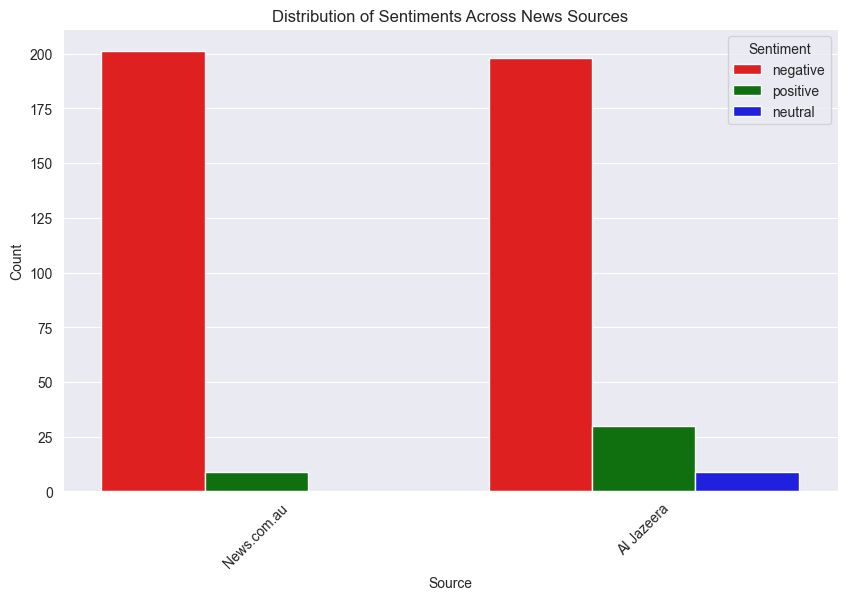

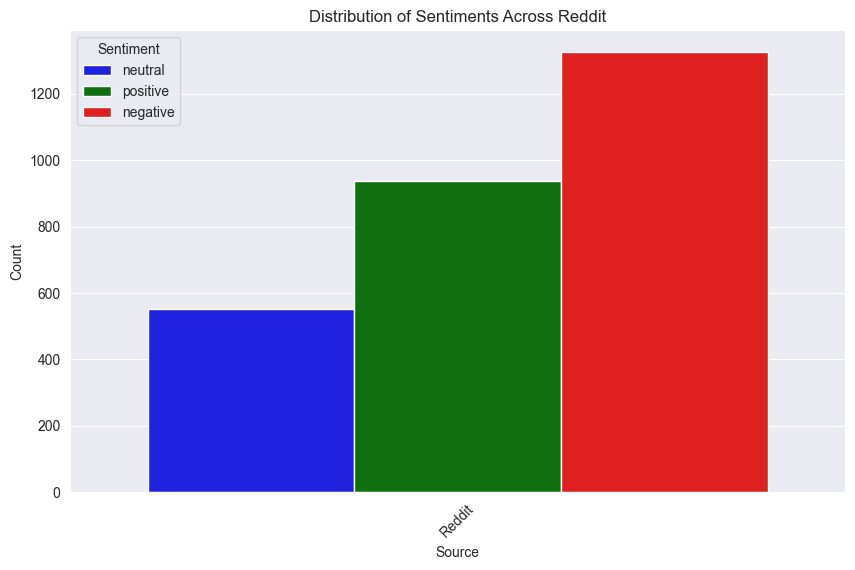

In [40]:
### Sentiment exploration
## News sites
sentiment_counts = news_data['adjusted_sentiment'].value_counts()
sentiment_counts_reddit = data_reddit['adjusted_sentiment'].value_counts()

print(sentiment_counts)
print(sentiment_counts_reddit)

# Define a color palette for sentiments
palette = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

## Plot for news sites
plt.figure(figsize=(10, 6))
sns.countplot(x='source', hue='adjusted_sentiment', data=news_data, palette=palette)
plt.title('Distribution of Sentiments Across News Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

## Plot for Reddit comments
plt.figure(figsize=(10, 6))
sns.countplot(x='source', hue='adjusted_sentiment', data=data_reddit, palette=palette)
plt.title('Distribution of Sentiments Across Reddit')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

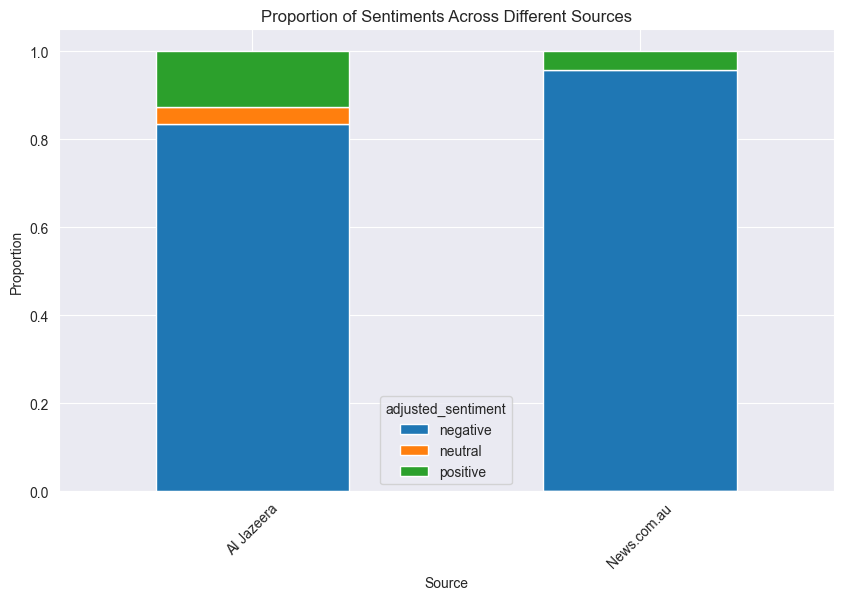

In [41]:
## Sentiment comparison by proportion
# Calculate the count of each sentiment for each source (before augmentation)
sentiment_counts = news_data.groupby(['source', 'adjusted_sentiment']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Plotting with matplotlib
sentiment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding titles and labels
plt.title('Proportion of Sentiments Across Different Sources')
plt.xlabel('Source')
plt.ylabel('Proportion')
plt.xticks(rotation=45)  # Rotate x-labels for better readability

plt.show()

Let's look at Sentiment over time for each data source

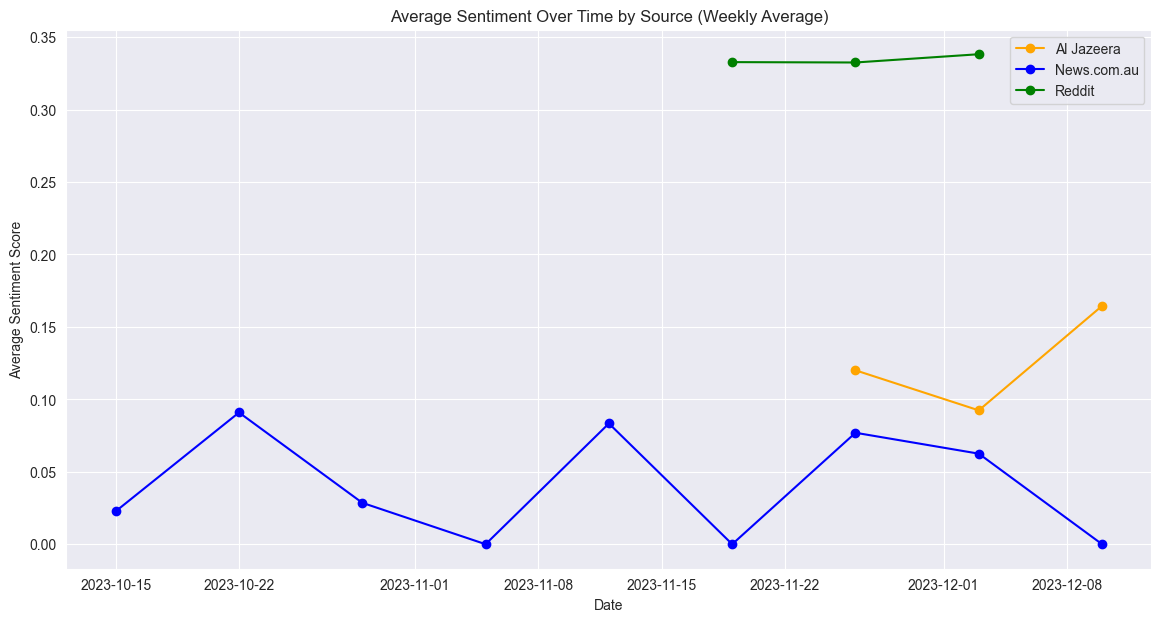

In [42]:
# Concatenate the news and Reddit data
all_data = pd.concat([news_data, data_reddit], ignore_index=True)

# Convert dates to datetime objects for the concatenated data
all_data['date'] = pd.to_datetime(all_data['date'])

# Calculate average sentiment score per day for each source
average_sentiment_per_day = all_data.groupby(['date', 'source'])['binary_label'].mean().reset_index()

# Pivot the data
pivot_avg_sentiment = average_sentiment_per_day.pivot(index='date', columns='source', values='binary_label')

# Resample by week and calculate mean
weekly_sentiment = pivot_avg_sentiment.resample('W').mean()

# Plotting
plt.figure(figsize=(14, 7))

# Define color mapping for sources
color_mapping = {
    'News.com.au': 'blue',
    'Al Jazeera': 'orange',
    'Reddit': 'green'  # Define a color for Reddit
}

for source in weekly_sentiment.columns:
    plt.plot(weekly_sentiment.index, weekly_sentiment[source], label=source, marker='o', color=color_mapping[source])

# Label the axes and title
plt.title('Average Sentiment Over Time by Source (Weekly Average)')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Display legend
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()


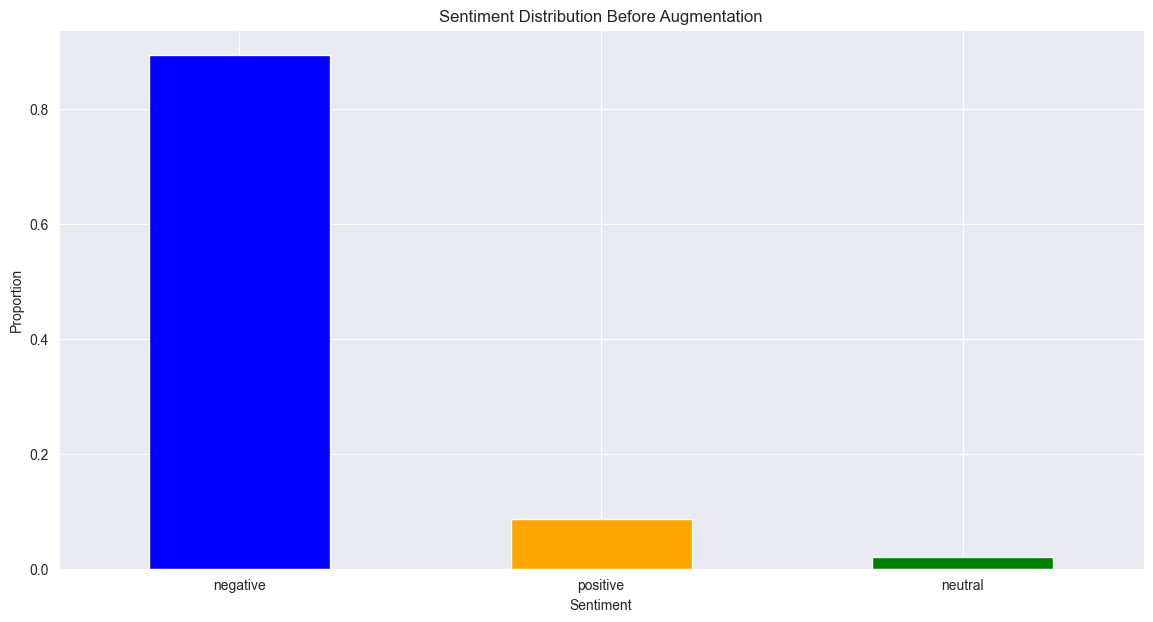

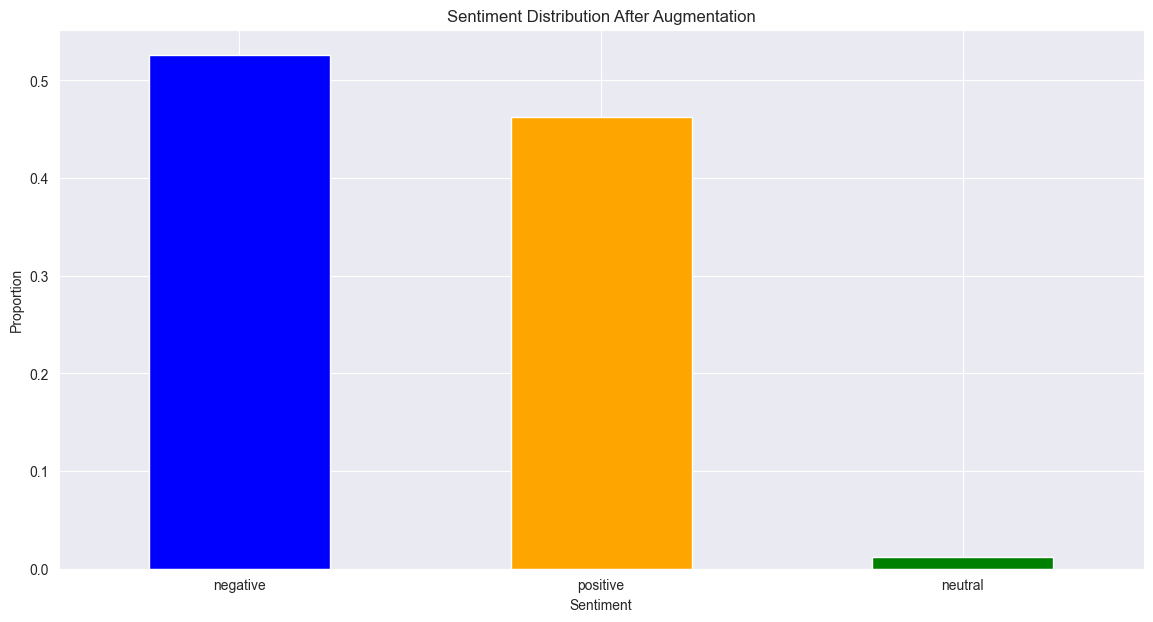

In [43]:
# Assuming data_reddit is your DataFrame with Reddit data and it has an 'adjusted_sentiment' column
positive_reddit_comments = data_reddit[data_reddit['adjusted_sentiment'] == 'positive']

# Shuffle the positive Reddit comments again
positive_reddit_comments = positive_reddit_comments.sample(frac=1).reset_index(drop=True)

# Take one third of the shuffled positive Reddit comments
one_third_positive_reddit_comments = positive_reddit_comments[:len(positive_reddit_comments)//3]

# Concatenate one third of the positive comments from Reddit with the news data
more_balanced_augmented_data = pd.concat([news_data, one_third_positive_reddit_comments], ignore_index=True)

# Shuffle the augmented data
more_balanced_augmented_data = more_balanced_augmented_data.sample(frac=1).reset_index(drop=True)


# Calc proportions
sentiment_counts_before = news_data['adjusted_sentiment'].value_counts(normalize=True)

more_balanced_sentiment_counts = more_balanced_augmented_data['adjusted_sentiment'].value_counts(normalize=True)


# Plotting the sentiment proportions before augmentation
plt.figure(figsize=(14, 7))
sentiment_counts_before.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Sentiment Distribution Before Augmentation')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Plotting the sentiment proportions after augmentation
plt.figure(figsize=(14, 7))
more_balanced_sentiment_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Sentiment Distribution After Augmentation')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

In [13]:
 # Save the combined data to a CSV file
more_balanced_augmented_data.to_csv('data_2_preprocessed_balanced.csv', index=False)

In [21]:
import torch
from transformers import LongformerTokenizer, LongformerForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from datasets import Dataset as HFDataset

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


In [22]:
# Reduce the dataset to 300 random records to reduce computation timehe risk of lowering the model's robustness)
more_balanced_augmented_data = more_balanced_augmented_data.sample(n=300, random_state=42)

more_balanced_augmented_data['processed_text'] = more_balanced_augmented_data['processed_text'].astype(str)
more_balanced_augmented_data['binary_label'] = more_balanced_augmented_data['binary_label'].astype(int)

# Tokenization
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
max_len = 900 # Because the median token corpus length is 817, this ensures most are safely captured without being too computationally heavy
encodings = tokenizer(more_balanced_augmented_data['processed_text'].tolist(), max_length=max_len, truncation=True, padding='max_length', return_tensors='pt')

# Custom dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Dataset creation
labels = more_balanced_augmented_data['binary_label'].tolist()
dataset = SentimentDataset(encodings, labels)

# Splitting the dataset into training and testing
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [23]:
# # Split the dataset into train and test sets
# train_dataset = hf_dataset.shuffle(seed=42).select(range(500))  # Randomly select 500 samples for training
# test_dataset = hf_dataset.shuffle(seed=42).select(range(500, 751))  # Use the rest for testing

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and training
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=2).to(device)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=720, training_loss=0.7214893129136827, metrics={'train_runtime': 15653.6061, 'train_samples_per_second': 0.046, 'train_steps_per_second': 0.046, 'total_flos': 415663910496000.0, 'train_loss': 0.7214893129136827, 'epoch': 3.0})

In [28]:
# Evaluate the model on the train set

eval_results_train = trainer.evaluate()
print(eval_results_train)

# Evaluate the model on the test set
eval_results_test = trainer.evaluate(val_dataset)
print(eval_results_test)

# Save the model
model.save_pretrained('model_1')
tokenizer.save_pretrained('model_1')

# If you want to predict on new data
predictions = trainer.predict(val_dataset)
print(predictions.predictions)
print(predictions.label_ids)
print(predictions.metrics)

{'eval_loss': 0.4588842988014221, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.9375, 'eval_precision': 0.9375, 'eval_recall': 0.9375, 'eval_runtime': 291.9161, 'eval_samples_per_second': 0.206, 'eval_steps_per_second': 0.206, 'epoch': 3.0}
{'eval_loss': 0.4588842988014221, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.9375, 'eval_precision': 0.9375, 'eval_recall': 0.9375, 'eval_runtime': 292.0037, 'eval_samples_per_second': 0.205, 'eval_steps_per_second': 0.205, 'epoch': 3.0}
[[ 3.5300179 -3.5855405]
 [-3.9788194  4.1329923]
 [-3.954434   4.1157947]
 [-3.078586   3.1949046]
 [ 3.4890924 -3.5778108]
 [-3.2739995  3.385394 ]
 [ 3.5528963 -3.5734026]
 [ 3.5655284 -3.5987217]
 [-3.9303436  4.041588 ]
 [ 3.4986024 -3.5617335]
 [-3.9412074  4.118337 ]
 [ 3.4172006 -3.5041914]
 [-3.945858   4.0852   ]
 [ 3.5723312 -3.6099286]
 [ 3.488229  -3.5694687]
 [ 3.5662856 -3.590884 ]
 [-3.8739188  4.0633144]
 [ 3.5208218 -3.5829859]
 [ 3.4898663 -3.5797567]
 [ 3.495647  -3.5896466]
 [ 3.50850

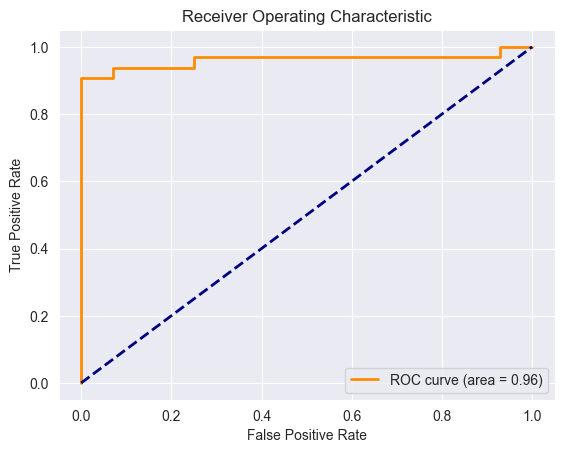

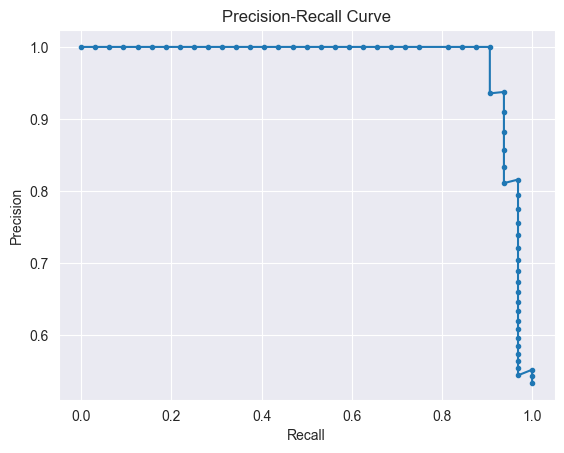

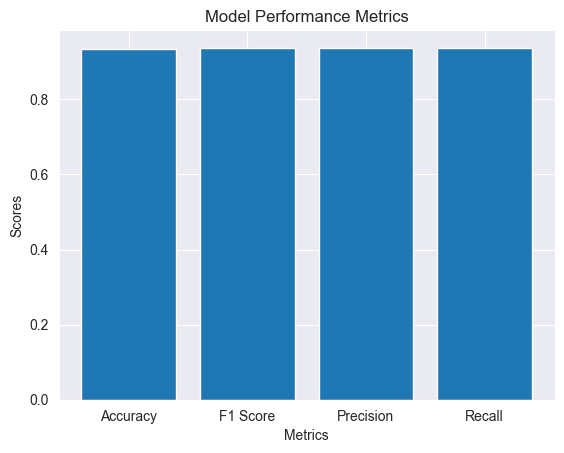

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

# Use the predictions and true labels to create a confusion matrix
conf_mat = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(predictions.label_ids, predictions.predictions[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(predictions.label_ids, predictions.predictions[:,1])

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

metrics = [predictions.metrics['test_accuracy'], predictions.metrics['test_f1'], predictions.metrics['test_precision'], predictions.metrics['test_recall']]
labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

plt.bar(labels, metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.show()


The below may be legacy, depending on how the above ML goes.

In [66]:
### SPLIT
import pandas as pd
from sklearn.model_selection import train_test_split
X = more_balanced_augmented_data['processed_text']
y = more_balanced_augmented_data['binary_label']

# Split the data - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
from transformers import RobertaModel, RobertaTokenizer
import torch.nn as nn
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

# Define your custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets (X_train, X_test, y_train, y_test should be defined)
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Create DataLoaders with multiple workers
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=4)



KeyboardInterrupt: 

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 3  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


NameError: name 'train_loader' is not defined

In [60]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, data_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    # Handle division by zero in precision and F-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary', zero_division=0
    )

    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.9518072289156626, Precision: 0.0, Recall: 0.0, F1 Score: 0.0


In [ ]:
# # Data Augmentation Part 1
# import numpy as np
# from scipy.spatial.distance import cosine
#
# def load_glove_model(glove_file_path):
#     glove_model = {}
#     with open(glove_file_path, 'r', encoding='utf-8') as file:
#         for line in file:
#             split_line = line.split()
#             word = split_line[0]
#             embedding = np.array(split_line[1:], dtype=np.float64)
#             glove_model[word] = embedding
#     return glove_model
#
# def find_closest_embeddings(embedding, embeddings, n=5):
#     return sorted(embeddings.keys(), key=lambda word: cosine(embeddings[word], embedding))[:n]
#
# glove_model = load_glove_model('path_to_glove.txt')
# # Data Augmentation Part 2
# def augment_sentence(sentence, glove_model, num_augmentations=1):
#     augmented_sentences = []
#     words = sentence.split()
#
#     for _ in range(num_augmentations):
#         new_sentence = words.copy()
#         word_idx = np.random.randint(0, len(words))
#         word = words[word_idx]
#         if word in glove_model:
#             closest_words = find_closest_embeddings(glove_model[word], glove_model)
#             synonym = np.random.choice(closest_words[1:])
#             new_sentence[word_idx] = synonym
#         augmented_sentences.append(' '.join(new_sentence))
#
#     return augmented_sentences
#
# # Augment the data
# augmented_text = []
# for sentence in combined_data['processed_text']:
#     augmented_text.extend(augment_sentence(sentence, glove_model, num_augmentations=2))
#
# # Add augmented data to DataFrame
# augmented_df = pd.DataFrame({'text': augmented_text, 'is_augmented': True})
# combined_data['is_augmented'] = False
# df_combined = pd.concat([combined_data, augmented_df], ignore_index=True)
